In [ ]:
! pip install path

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl
import sys

from collections import defaultdict
from functools import reduce
from path import Path
from pprint import pprint
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 10,6

In [ ]:
sys.path.append('/content/drive/MyDrive/퀀트/library')

In [ ]:
from sampling import dollar_bars
from filters import cusum
from multiprocess_r import mpPandasObj
from load_data import load_contracts
from labeling import getEvents, getVerticalBarriers, getBins
from util import getDailyVol

### IID Gaussian random process

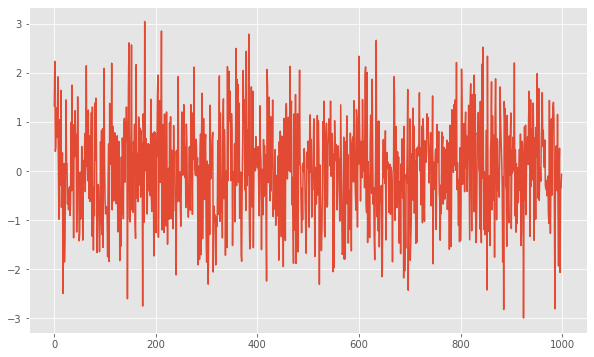

In [ ]:
normal = pd.Series(np.random.normal(size=1000))
normal.plot();

In [ ]:
print("P-Value:", adfuller(normal)[1])

P-Value: 0.0


### Cumulative Sum of IID Gaussian 

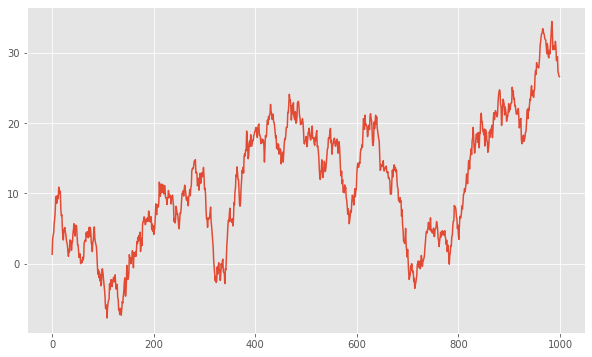

In [ ]:
n_cum = normal.cumsum()
n_cum.plot();

In [ ]:
print("P-Value:", adfuller(n_cum)[1])

P-Value: 0.5024999032389978


## FFD

- 확장되는 윈도우

In [ ]:
def getWeights(d, size):
    # thresh > 0 drops insignificant weights
    w = [1.0] # 처음 가중값 w_0은 1
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1) # 가중값 계산 
        w.append(w_) 
    w = np.array(w[::-1]).reshape(-1, 1) # 가중값을 역순으로, (N, 1)로 reshape
    return w # 즉 작은 것부터 큰 순서대로, 마지막이 1인 것으로 저장되어있음 

In [ ]:
def fracDiff(series, d, thres=0.01):
    # 1) getWeights 함수로 가중값 계산 
    w = getWeights(d, series.shape[0])
    # 2) 가중값 손실 임계값에 기반해 초기 skip 결정
    w_ = np.cumsum(abs(w)) # 절댓값(가중값) 누적, 가중값 손실식에서 시그마로 표현 
    w_ /= w_[-1] # 가중값 손실식 표현 (전체 누적값으로 나눠줌)
    skip = w_[w_ > thres].shape[0] # 임계값보다 큰 값의 갯수, 이 skip이전의 값은 모두 삭제 
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        # seriesF: 만약 na가 있다면 앞의 걸로 대체해서 데이터 저장, df_: 데이터 인덱스
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index) 
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc] # loc에 iloc인덱스 저장
            if not np.isfinite(series.loc[loc, name]):
                continue # skip부터 N까지 무한한 값있다면 제외 
            a = w[-(iloc + 1):, :].T # 끝에서부터 iloc갯수만큼 가중치 값 선택
            b = seriesF.loc[:loc] # 가중치에 대응하는 x값 
            df_[loc] = np.dot(a, b)[0, 0] # 둘의 내적
        df[name] = df_.copy(deep=True) # id를 따로 만들어서 복사 
    df = pd.concat(df, axis=1) # df 갱신 
    return df

In [ ]:
for d in np.arange(0, 1.0, 0.05):
    s = fracDiff(n_cum.to_frame('s'), d)['s'].dropna() # 데이터에 대해 칼럼 이름은 s로 한 후 na 제거
    p_val = adfuller(s)[1] # ADF 검정
    if p_val < 0.05: # d를 (0, 1)로 0.05간격으로 돌면서 정상 시계열을 만들어주는 d 프린트
        print("The minimum d value with a p-value below 5% is:")
        print(d)
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if

The minimum d value with a p-value below 5% is:
0.35000000000000003


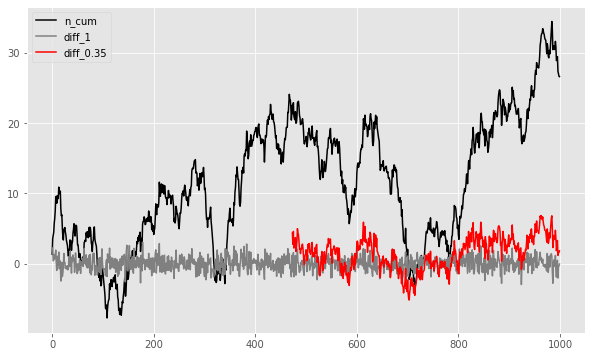

In [ ]:
mpl.plot(n_cum, label='n_cum', color='black')
mpl.plot(range(1, len(n_cum)), n_cum.diff(1).dropna(), label='diff_1', color='gray')
mpl.plot(range(len(n_cum) - len(s),len(n_cum)), s, label='diff_0.35', color='red')
mpl.legend()

- 고정되는 윈도우

In [ ]:
def getWeights_FFD(d, thres):
    w, k = [1.0], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres: # 가중값에 임계값 적용 
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres):
    # Constant with window (new solution)
    w =  getWeights_FFD(d, thres)
    width, df = len(w) - 1, {} 
    
    for name in series.columns:
        seriesF, df_ = series[[name]].fillna(method='ffill').dropna(), pd.Series(index=series.index)
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1] # loc0: 임계값 이상인 위
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [ ]:
for d in np.arange(0, 1.0, 0.05):
    s_w = fracDiff_FFD(n_cum.to_frame('s_w'), d, 1e-4)['s_w'].dropna() # 데이터에 대해 칼럼 이름은 s로 한 후 na 제거
    p_val = adfuller(s_w)[1] # ADF 검정
    if p_val < 0.05: # d를 (0, 1)로 0.05간격으로 돌면서 정상 시계열을 만들어주는 d 프린트
        print("The minimum d value with a p-value below 5% is:")
        print(d)
        break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: Deprecation

The minimum d value with a p-value below 5% is:
0.30000000000000004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


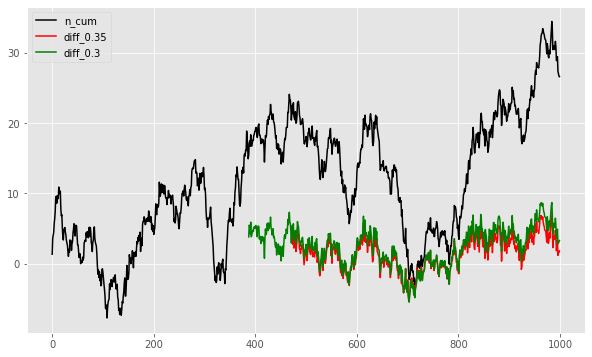

In [ ]:
mpl.plot(n_cum, label='n_cum', color='black')
mpl.plot(range(len(n_cum) - len(s),len(n_cum)), s, label='diff_0.35', color='red')
mpl.plot(range(len(n_cum) - len(s_w),len(n_cum)), s_w, label='diff_0.3', color='green')
mpl.legend()

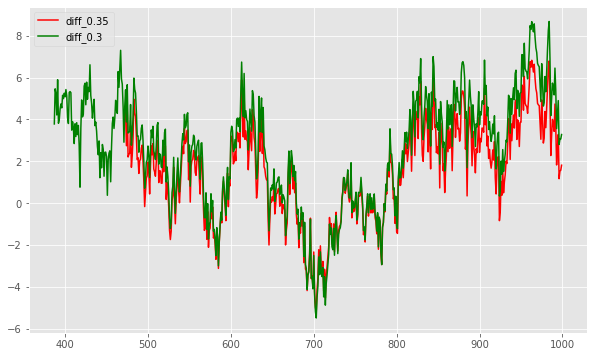

In [ ]:
mpl.plot(range(len(n_cum) - len(s),len(n_cum)), s, label='diff_0.35', color='red')
mpl.plot(range(len(n_cum) - len(s_w),len(n_cum)), s_w, label='diff_0.3', color='green')
mpl.legend()